The models that will be used to predict heart disease:
<ul>
    <li>Random Forest Classifier</li>
    <li>Support Vector Machine</li>
    <li>Decision Tree Classifier</li>
</ul>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import time

In [4]:
path = '../data/processed/heart_2020_preprocessed.csv'

In [5]:
df = pd.read_csv(path, index_col=0)
df.head()

,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Diabetic_Yes,PhysicalActivity_Yes,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes,Dummy_Sex,BMI,PhysicalHealth,MentalHealth,SleepTime,Code_AgeCategory,Code_GenHealth,Race
0,0,1,0,0,0,1,1,1,0,1,0,-1.844750,-0.046751,3.281069,-1.460354,7,3,White
1,0,0,0,1,0,0,1,0,0,0,0,-1.256338,-0.424070,-0.490039,-0.067601,12,3,White
2,0,1,0,0,0,1,1,1,0,0,1,-0.274603,2.091388,3.281069,0.628776,9,1,White
3,0,0,0,0,0,0,0,0,0,1,0,-0.647473,-0.424070,-0.490039,-0.763977,11,2,White
4,0,0,0,0,1,0,1,0,0,0,0,-0.726138,3.097572,-0.490039,0.628776,4,3,White


In [6]:
df.shape

(319795, 18)

<h3>Setting up the training and test sets</h3>

Since the race feature is of type string, it will be dropped in order to use the random forest classifier. The race feature could also be transformed to be represented numerical but for simiplicity this has not been done.

In [7]:
#Setting the independent features.
X = df.drop(['HeartDisease_Yes','Race'], axis=1)
X.head(3)

,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Diabetic_Yes,PhysicalActivity_Yes,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes,Dummy_Sex,BMI,PhysicalHealth,MentalHealth,SleepTime,Code_AgeCategory,Code_GenHealth
0,1,0,0,0,1,1,1,0,1,0,-1.844750,-0.046751,3.281069,-1.460354,7,3
1,0,0,1,0,0,1,0,0,0,0,-1.256338,-0.424070,-0.490039,-0.067601,12,3
2,1,0,0,0,1,1,1,0,0,1,-0.274603,2.091388,3.281069,0.628776,9,1


In [8]:
#Setting the heart disease feature as the dependent variable.
y = df[['HeartDisease_Yes']]
y.head(3)

,HeartDisease_Yes
0,0
1,0
2,0


In [51]:
#Create a train and test set with 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

<h2>Random Forest Classifier</h2>

In [61]:
clf = RandomForestClassifier(n_estimators = 100)
model = clf.fit(X_train, np.array(y_train).reshape(1,-1)[0])

In [11]:
pred = model.predict(X_test)

In [12]:
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred, average='weighted'))

0.9044913955742712
0.8829306260418002


With this given training and test set, the model made predictions with roughly 90% accuracy.

In [13]:
#[tn, fn, fp, tp]
print(confusion_matrix(y_test, pred).ravel())

[85771  1893  7270  1005]


In [14]:
print(confusion_matrix(y_test,pred))

[[85771  1893]
 [ 7270  1005]]


In [15]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     87664
           1       0.35      0.12      0.18      8275

    accuracy                           0.90     95939
   macro avg       0.63      0.55      0.56     95939
weighted avg       0.87      0.90      0.88     95939



The importance of each feature in the Random Forest Classifier will be graphed and then the most influential features will be used for feature selecting in the SVM model.

16


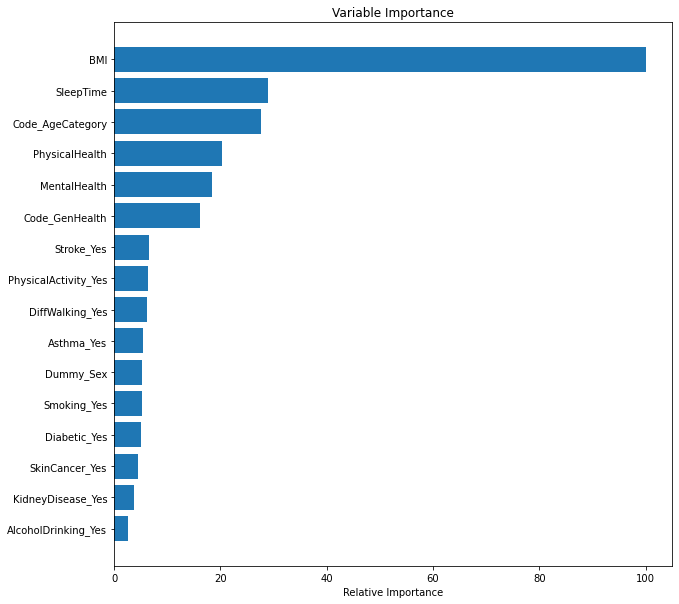

In [16]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance/feature_importance.max())[:16]
sorted_idx = np.argsort(feature_importance)[:16]

pos = np.arange(sorted_idx.shape[0]) + 0.5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The above bar graph suggests that BMI and amount of sleep are the most determining factors of heart disease based on this dataset. Though I wonder if the value of these features is affecting the feature important. Specially BMI is represented here as a range of values while Smoking, and many other features here, are either "Yes" or "No".

<h1>Support Vector Machine</h1>

The top three influential features (BMI, Sleep Time, and Age Category) will be fitted to the SVM model as fitting all features requires a lot of computational resources.

In [22]:
svm_clf = SVC()
start_time = time.time()
svm_clf.fit(X_train[['BMI', 'SleepTime', 'Code_AgeCategory']], np.array(y_train).reshape(1,-1)[0])
print('%s seconds' % (time.time() - start_time))

240.4656002521515 seconds


In [39]:
svm_pred = svm_clf.predict(X_test[['BMI','SleepTime', 'Code_AgeCategory']])

In [17]:
print('Accuracy: ' + str(accuracy_score(y_test, svm_pred)))
print('F1_score: ' + str(f1_score(y_test,svm_pred, average='weighted')))

Accuracy: 0.9147687593158152
F1_score: 0.8740500689171489


With the Support Vector Machine model, accuarcy was slightly higher than with the Random Forest Classifier.

In [18]:
confusion_matrix(y_test, svm_pred)

array([[87762,     0],
       [ 8177,     0]], dtype=int64)

<h2>SVM with RandomizedSearchCV</h2>

In [23]:
params = {'C': np.arange(0.25,2,0.25)}

start_time= time.time()

clf = RandomizedSearchCV(svm_clf, param_distributions=params, cv=5, n_iter=5)
SVM_RSCV = clf.fit(X_train[['BMI', 'SleepTime', 'Code_AgeCategory']], np.array(y_train).reshape(1,-1)[0])
SVM_RSCV.best_params_

print(time.time()-start_time)

3995.806172132492


Over one hour to perform 5 iterations of random grid search with 5 level cross validation with only adjusting the C hypermeter. There are severl other hyperparameters to tune but the even randomized grid search takes a considerable amount of time. 

In [24]:
SVM_RSCV.best_params_

{'C': 1.25}

In [55]:
SVM_RSCV_tuned = SVC(C=1.25)
SVM_RSCV_tuned_fit = SVM_RSCV_tuned.fit(X_train[['BMI', 'SleepTime', 'Code_AgeCategory']], np.array(y_train).reshape(1,-1)[0])

In [59]:
SVM_RSCV_pred = SVM_RSCV_tuned_fit.predict(X_test[['BMI', 'SleepTime', 'Code_AgeCategory']])

In [60]:
accuracy_score(y_test, SVM_RSCV_pred)

0.915081458009777

Accuracy with the tuned hypermeter did not lead to much more accuracy than the default settings for this given data set.

<h2>Decision Tree Model with RandomizedSearchCV</h2>

In [28]:
tree = DecisionTreeClassifier()
params = {'max_depth': np.arange(1,16)}
clf = RandomizedSearchCV(tree, param_distributions=params, cv=5)

In [29]:
search = clf.fit(X_train, y_train)

In [30]:
search.best_params_

{'max_depth': 5}

In [31]:
tree_model = DecisionTreeClassifier(max_depth = 5)
tree_clf = tree_model.fit(X_train, y_train)

In [32]:
tree_pred = tree_clf.predict(X_test)

In [33]:
accuracy_score(y_test, tree_pred)

0.9148000291852114

Below, all possible tree depths will be explored which we can then use to verify if the max depth of 5 as determined from the RandomForestClassifier compares to the other max depths.

In [34]:
scores = []
for i in np.arange(1,16):
    sub_tree = DecisionTreeClassifier(max_depth=i)
    sub_model = sub_tree.fit(X_train, y_train)
    sub_pred = sub_model.predict(X_test)
    scores.append((accuracy_score(y_test, sub_pred),f1_score(y_test,sub_pred, average='weighted'), sub_model.get_params()['max_depth']))

In [35]:
scores

[(0.91374727691554, 0.8725646234922512, 1),
 (0.91374727691554, 0.8725646234922512, 2),
 (0.9138827796829235, 0.8829899353109144, 3),
 (0.9142684414054764, 0.8754095713825321, 4),
 (0.9148000291852114, 0.8809913160556742, 5),
 (0.9149772251117898, 0.8817989958779823, 6),
 (0.9144039441728599, 0.8823228143732742, 7),
 (0.9142163249564828, 0.8855248477867741, 8),
 (0.9137264303359426, 0.8835887252541516, 9),
 (0.9132156891358051, 0.8837272881994925, 10),
 (0.9114333065802228, 0.8838874423283914, 11),
 (0.9099115062696088, 0.885138805959896, 12),
 (0.9078893880486559, 0.8845220553088007, 13),
 (0.9060444657542813, 0.8842858339838575, 14),
 (0.9030738281616444, 0.8838889838060613, 15)]

If accuarcy is the determing score then a max depth of 5 provides the most accurate predictions.

<h3>Conclusion</h3>
Of the three models used, the support vector machine model with its hyperparameter C set to 1.25 had the highest accuracy of 0.915. Though to the Decision Tree tuned with random grid search yielded a very close accuracy rate of 0.9149, and required significantly less time to tune.